# Deep Learning for NLP - Exercise 01
Building, Tuning and Evaluating a standard RNN Model

General hints:
* Have a look at the imports below when solving the tasks
* Use the given modules and all submodules of the imports, but don't import anything else!
    * For instance, you can use other functions under the `torch` or `nn` namespace, but don't import e.g. PyTorch Lightning, etc.
* It is recommended to install all packages from the provided environment file
* Feel free to test your code between sub-tasks of the exercise sheet, so that you can spot mistakes early (wrong shapes, impossible numbers, NaNs, ...)
* Just keep in mind that your final submission should be compliant to the provided initial format of this file

Submission guidelines:
* Make sure that the code runs on package versions from the the provided environment file
* Do not add or change any imports (also don't change the naming of imports, e.g. `torch.nn.functional as f`)
* Remove your personal, additional code testings and experiments throughout the notebook
* Do not change the class, function or naming structure as we will run tests on the given names
* Additionally export this notebook as a `.py` file, and submit **both** the executed `.ipynb` notebook with plots in it **and** the `.py` file
* **Deviation from the above guidelines will result in partial or full loss of points**

If you are using Google Colab or similar services, make sure to install all necessary packages so that the import cell below is working.

Usually, you would need to `!pip install`:
```
!pip install datasets==3.0.1
!pip install spacy==3.6.1
!pip install torch==2.0.1    # just to be sure we are all working with the same version
!pip install torchtext==0.15.2
!python -m spacy download en_core_web_sm
```

Make sure to comment out the lines before submitting!

In [ ]:
!pip install datasets==3.0.1
!pip install spacy==3.6.1
!pip install torch==2.0.1    # just to be sure we are all working with the same version
!pip install torchtext==0.15.2
!python -m spacy download en_core_web_sm

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.6.1 which is incompatible.
   ━━━━━━━━━

In [ ]:
import os
import sys
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Sampler, BatchSampler, Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

from datasets import load_dataset

In [ ]:
def regularized_f1(train_f1, dev_f1, threshold=0.0015):
    """
    Returns development F1 if overfitting is below threshold, otherwise 0.
    """
    return dev_f1 if (train_f1 - dev_f1) < threshold else 0


def save_metrics(*args, path, fname):
    if not os.path.exists(path):
        os.makedirs(path)
    if not os.path.isfile(path + fname):
        with open(path + fname, "w", newline="\n") as f:
            f.write(
                ",".join(
                    [
                        "config",
                        "epoch",
                        "train_loss",
                        "train_acc",
                        "train_f1",
                        "val_loss",
                        "val_acc",
                        "val_f1",
                    ]
                )
            )
            f.write("\n")
    if args:
        with open(path + fname, "a", newline="\n") as f:
            f.write(",".join([str(arg) for arg in args]))
            f.write("\n")

def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(1234)

In [ ]:
VOCAB_SIZE = 20_000
BATCH_SIZE = 32
NUM_EPOCHS = 15
MAX_LEN = 256
LEARNING_RATE = 1e-4

## Task 1 - Download and prepare the dataset
- Load the train and test set of IMDB (it is included in the `datasets` module we imported above)
- Split the train set into train and validation set
    * Train set should consist of the middle 10% to 85% of data
    * Validation set should be the two remaining ends
    * You can achieve this slicing directly within the `load_dataset` function, check out the [Huggingface slicing API](https://huggingface.co/docs/datasets/v2.13.1/loading#slice-splits)
- Test set should stay unchanged

In [ ]:
# load dataset in splits
train_data = load_dataset("imdb", split="train[10%:85%]")
dev_data = load_dataset("imdb", split="train[:10%]+train[85%:]")
test_data = load_dataset("imdb", split="test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

* Define the tokenizer using `get_tokenizer` with spacy's `en_core_web_sm` module
    * You don't have to import spacy for that, but it is necessary to have spacy installed and the `en_core_web_sm` module downloaded
* Create the vocabulary using `build_vocab_from_iterator`
    * Think about which split(s) should be used to build the vocabulary
    * Include two special tokens: `'<UNK>'` at index `0`, `'<PAD>'` at index `1`
    * Limit the vocab size to `VOCAB_SIZE`, as defined in the beginning
    * Set the vocab's default returning index to `0` by making the `'<UNK>'` token default
    
Hint:
* This might be a good moment to add a personal test to check whether your vocab actually returns `0` for an unknown input token

In [ ]:
# define tokenizer
tokenizer = get_tokenizer("spacy", language="en_core_web_sm")

# define vocabulary
vocab = build_vocab_from_iterator(
    #use all the data for building the vocabulary to get the most exhaustive number of tokens?
    #Tokenize each
    (tokenizer(review) for review in train_data[:]["text"]),
    specials=['<UNK>', '<PAD>'],
    max_tokens= VOCAB_SIZE,
    special_first = True
)
vocab.set_default_index(vocab['<UNK>'])

In [ ]:
vocab.get_itos()

['<UNK>',
 '<PAD>',
 'the',
 ',',
 '.',
 'a',
 'and',
 'of',
 'to',
 'is',
 'in',
 'I',
 'it',
 'that',
 '"',
 "'s",
 'this',
 '-',
 '/><br',
 'was',
 'as',
 'with',
 'movie',
 'for',
 'film',
 'The',
 'but',
 "n't",
 '(',
 'on',
 ')',
 'you',
 'are',
 'not',
 'have',
 'his',
 'be',
 'he',
 'one',
 '!',
 'at',
 'by',
 'all',
 'an',
 'who',
 'they',
 'like',
 'from',
 'so',
 'or',
 "'",
 'her',
 'about',
 'has',
 'just',
 'It',
 'out',
 'do',
 '?',
 'good',
 'some',
 'more',
 'would',
 'very',
 'up',
 'what',
 'there',
 'This',
 'time',
 'can',
 'when',
 'if',
 'which',
 'had',
 'only',
 'really',
 'she',
 'were',
 'even',
 'story',
 'no',
 'see',
 'their',
 'my',
 'did',
 'does',
 'me',
 'than',
 '...',
 'much',
 'could',
 ':',
 'been',
 'get',
 'into',
 'bad',
 'people',
 'we',
 'well',
 'will',
 'other',
 'because',
 'him',
 'first',
 'made',
 'great',
 'most',
 'make',
 'them',
 '<',
 'way',
 'how',
 'also',
 'br',
 'any',
 'its',
 'movies',
 'too',
 '/>The',
 'think',
 'characters'

* Use the tokenizer and vocabulary to turn your three data splits into indices
* Limit the maximum tokenized sequence length to `MAX_LEN`

**Note**:
In practice, performing this step on its own during the preprocessing stage is usually not feasible due to the memory constraints associated with storing large datasets. Consequently, the tokenization and indexing steps are typically performed "on the fly" within the `DataLoader`, specifically in the `collate_batch` step.

In [ ]:
#Each review is first tokenized to create a list of tokens and then mapped to the indices given by vocab
train_idx = [[vocab[token] for token in tokenizer(review["text"])[:MAX_LEN]] for review in train_data]
dev_idx = [[vocab[token] for token in tokenizer(review["text"])[:MAX_LEN]] for review in dev_data]
test_idx = [[vocab[token] for token in tokenizer(review["text"])[:MAX_LEN]] for review in test_data]

In [ ]:
#TODO: remove
#Maximum number of tokens in review should be 256
max(len(inner_list) for inner_list in train_idx)

256

* Define a torch dataset by inhereting from `Dataset`
* It should create the building block to return the tokenized indices and labels for a given index
* Instantiate it

In [ ]:
class ImdbDataset(Dataset):
    def __init__(self, seq, lbl):
       self.data = seq
       self.labels = lbl

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx]), torch.tensor(self.labels[idx])

    def __len__(self):
        return len(self.labels)

In [ ]:
#stored the training data reviews (as a list containing sublists of tokens/integers) in the data field
# and the labels in the labels field
train_set = ImdbDataset(train_idx, train_data[:]["label"])

In [ ]:
train_set.labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


* Having batches in which samples have a similar length, and thus less padding variations, improves training results
* A `GroupedSampler` allows us to create a sampler with which we can customize the data loading process
* It can then be implemented into the `DataLoader`, which automates loading data in multiple processes
* Write a sampler which allows us to group together samples of similar length into a batch
    * The `GroupedSampler` takes as input the tokenized sequences from `ImdbDataset`, as well as the batch size
    * First, in the `__init__` method, pair each sequence index with its tokenized sequence length
        * The result should be a list of tuples: `[(index, tokenized_sequence_length), ...]`
    * In the `__iter__` method, we now:
        * Shuffle the list
        * generate groups of size `BATCH_SIZE * 100`
        * Each group of size `BATCH_SIZE * 100` should be sorted in itself by the sequence length we calculated above
            * Sorting within each group is important because sorting based on the whole dataset would eliminate all training input variations
            * By shuffling in the `__iter__` method, we shuffle the set of indices in each new iteration (which equals an epoch), therefore, we keep input variation
        * The result should be a list of tuples sorted by ascending sequence length: `[(index, tokenized_sequence_length), ...]`
        * After each `BATCH_SIZE * 100` number of tuples, the sequence length of samples should drop and increase again
        * Example:
            ```
            Sample index 3199: (1234, 256)
            Sample index 3200: (567, 32)
            Sample index 3201: (890, 33)
            ```
        * Filter the created and sorted list to only consist of indices. Make sure to keep the sorting!
        * Return this list as an iterator
    * Complete the `__len__` method

In [ ]:
class GroupedSampler(Sampler):
    def __init__(self, seqs, batch_size):
        self.batch_size = batch_size
        self.seqs = seqs
        self.sequence_lengths = [(idx, len(sequence)) for (idx, sequence) in enumerate(seqs.data)]

    def __iter__(self):
        random.shuffle(self.sequence_lengths)
        #generate groups of size batchsize*100 as a list containing the sublists of size batchsize*100
        groups = [self.sequence_lengths[i:i + self.batch_size*100]
                    for i in range(0, len(self.sequence_lengths), self.batch_size*100)]
        #sort by the second tuple value in each of the sublists
        sorted_groups = [sorted(group, key=lambda x: x[1]) for group in groups]
        #until now I have a list of sublists but now it is supposed to be merged into one larger list
        #concatenated_groups = [item for sublist in sorted_groups for item in sublist]
        #only the index is returned for the final list, meaning only the first element of each tuple in the list
        final_groups = [tuple[0] for subgroup in sorted_groups for tuple in subgroup]
        #output should be a one-dimensional list
        return iter(final_groups)

    def __len__(self):
        return len(self.seqs)

In [ ]:
#TESTS!
list_of_tuples = [(i, random.randint(0, 100)) for i in range(101)]
        #generate groups of size batchsize*100 as a list containing the sublists of size batchsize*100
groups = [list_of_tuples[i:i + 10] for i in range(0, len(list_of_tuples), 10)]
print(f"{groups=}")
        #sort by the second tuple value in each of the sublists
sorted_groups = [sorted(group, key=lambda x: x[1]) for group in groups]
print(f"{sorted_groups=}")
        #until now I have a list of sublists but now it is supposed to be merged into one larger list
#concatenated_groups = [item for sublist in sorted_groups for item in sublist]
#print(f"{concatenated_groups=}")
        #only the index is returned for the final list, meaning only the first element of each tuple in the list
final_groups = [[tuple[0] for tuple in subgroup] for subgroup in sorted_groups]
print(f"{final_groups=}")

groups=[[(0, 99), (1, 56), (2, 14), (3, 0), (4, 11), (5, 74), (6, 4), (7, 85), (8, 88), (9, 10)], [(10, 12), (11, 98), (12, 45), (13, 30), (14, 2), (15, 3), (16, 100), (17, 2), (18, 44), (19, 82)], [(20, 79), (21, 61), (22, 78), (23, 59), (24, 19), (25, 11), (26, 23), (27, 91), (28, 14), (29, 1)], [(30, 64), (31, 62), (32, 31), (33, 8), (34, 85), (35, 69), (36, 59), (37, 8), (38, 76), (39, 86)], [(40, 11), (41, 65), (42, 74), (43, 5), (44, 34), (45, 71), (46, 8), (47, 82), (48, 38), (49, 61)], [(50, 45), (51, 34), (52, 31), (53, 83), (54, 25), (55, 58), (56, 67), (57, 85), (58, 2), (59, 65)], [(60, 9), (61, 0), (62, 42), (63, 18), (64, 90), (65, 60), (66, 84), (67, 48), (68, 21), (69, 6)], [(70, 9), (71, 75), (72, 63), (73, 20), (74, 9), (75, 71), (76, 27), (77, 18), (78, 3), (79, 44)], [(80, 98), (81, 14), (82, 67), (83, 18), (84, 85), (85, 39), (86, 58), (87, 5), (88, 53), (89, 35)], [(90, 84), (91, 5), (92, 22), (93, 34), (94, 19), (95, 38), (96, 19), (97, 99), (98, 59), (99, 5)], [

* Now create the `GroupedSampler`, use it as input to create a `BatchSampler` (imported in the beginning)

In [ ]:
train_grouped_sampler = GroupedSampler(seqs=train_set, batch_size=BATCH_SIZE)
train_sampler = BatchSampler(train_grouped_sampler, batch_size=BATCH_SIZE, drop_last=False)
#Each train_sampler instance returns a different set of batches for the training data (in total 586 batches of length 32)

In [ ]:
len(list(train_sampler))

586

* Define a collate function which takes in a `batch` of tokenized sequences and labels created by the `BatchSampler`
    * Make sure to understand the structure of an input `batch`. Test around a bit to see what exactly they return.
* The collate function then:
    * pads these indices to the same length
        * use `padding_value=1`, `0` should be reserved for `UNK` token
    * turns the labels into tensors
    * finally, it creates a tensor which stores the length of all tokenized sentences **before** padding
    * the function should return 3 batched tensors: sequences, labels, lengths

In [ ]:
# define collate function
#QUESTION: It takes in a single batch or the whole set of batches as an epoch?
def collate_batch(batch):
    #list of labels and reviews (data) corresponding to the labels/reviews of the batch
    sequences, labels = zip(*batch)
    #batch_labels = torch.tensor([train_set.labels[idx] for idx in batch])// not necessary because the dataloader already does this for you
    #batch_data = torch.tensor([train_set.data[idx] for idx in batch])
    #list of lengths of each review in the batch
    batch_sequence_lengths = torch.tensor([len(seq) for seq in sequences])
    #batch_first = True or False?
    padded_data = pad_sequence(sequences=sequences, padding_value=1, batch_first=True)
    return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)

* Now create the final `DataLoader` for the train set
    * For your training, set the number of workers to your liking/cpu cores setup
    * When submitting this exercise, please set `num_workers=2` at maximum
* Repeat the `DataLoader` creation process for the validation and test set
    * It is not necessary to introduce randomness into the validation and test set
    * Create an `ImdbDataset` and `DataLoader` instance
    * leave `shuffle` off and don't include any Samplers
    * still include the correct batch size and collate function

In [ ]:
# create dataloaders
train_loader = DataLoader(
    dataset=train_set,
    batch_sampler=train_sampler,
    collate_fn=collate_batch,
    num_workers=0,
)

dev_loader = DataLoader(
    dataset=ImdbDataset(dev_idx, dev_data[:]["label"]),
    batch_size=BATCH_SIZE,
    collate_fn=collate_batch,
    num_workers=0,
)

test_loader = DataLoader(
    dataset=ImdbDataset(test_idx, test_data[:]["label"]),
    batch_size=BATCH_SIZE,
    collate_fn=collate_batch,
    num_workers=0,
)

## Task 2 - Build Your Model
The model should consist of:
- an **embedding layer**, which takes `vocab_size` and `embedding_dim` as parameters
- a **dropout layer**, which takes `dropout` as a parameter
- an **LSTM layer**, which takes `embedding_dim` and `rnn_size` as parameters, and is bidirectional
- a **linear layer**, which takes the dimension of rnn output as input dimension and returns an output of `hidden_size` dimensions
- a **linear layer**, which first takes the previous layers output as input and returns one prediction per class of the dataset
- the output of the BiLSTM has hidden representation tensors for each index of each sequence. However, for the task of sequence classification, we just need one hidden representation tensor per sequence. Use `torch.mean()` as a pooling function for dimensionality reduction.
- use **dropout** on the embeddings and appropriate linear layer
- use **ReLU** as the activation function on the appropriate linear layer

_Hints:_
  - keep the position of the batch dimension equal across all layers
  - _use `pack_padded_sequence`_ and `pad_packed_sequence` at the appropriate steps. For more information, check out [this answer on stackoverflow](https://stackoverflow.com/a/56211056)
  - remember to include the `padding_idx=1` at relevant positions
  - as this is a binary classification task, it is possible to have 1 or 2 output neurons. Use your preference, but adjust the loss function towards your choice

In [ ]:
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, rnn_size, hidden_size, dropout):
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
            padding_idx=1
        )
        self.dropout = nn.Dropout(
            dropout,
        )
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=rnn_size,
            bidirectional=True,
            batch_first = True #because linear layer needs batch as 0-th dimension
        )
        self.linear1 = nn.Linear(
            in_features=2*rnn_size, #because lstm is bidirectional
            out_features=hidden_size
        )
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(
            in_features=hidden_size,
            out_features=1
        )



    def forward(self, seq, lengths):
        #Apply the embedding to each sequence -> embedding dimensionality
        seq = self.embedding(seq)
        seq = self.dropout(seq) # Use dropout on the embedding layer
        packed_sequences = pack_padded_sequence(seq, lengths=lengths, batch_first=True, enforce_sorted=False)
        output, (_, _) = self.lstm(packed_sequences)
        padded_output, _ = pad_packed_sequence(output, batch_first=True)
        #pad before or after the pooling?
        pooled_output = torch.mean(padded_output, dim=1)
        #output = all output hidden states of lstm ()
        seq = self.linear1(pooled_output)
        seq = self.dropout(seq)
        seq = self.relu(seq)
        seq = self.linear2(seq)
        return seq.squeeze()

## Task 3 - Inner train loop
* Create a global `device` variable which checks whether a GPU is available or not, and sets the device to either GPU or CPU.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

* Write the inner train/test loop by completing the function `process`.
    * It takes the model, a dataloader, criterion and optionally the optimizer
    * The function iterates once through the dataloader, i.e. one epoch
    * Include the `tqdm` functionality for the loop through the dataloader by placing the loader inside `tqdm()`
        * Print its output to `file=sys.stdout`, and use `'batches'` as unit
        * You can also add a `desc='...'` to get a marking whether we currently train or evaluate
    * The function also moves the sequences and labels to `device`
    * The `lengths` need to stay on CPU!
    * If the optimizer is given, training with backpropagation is performed, then the below defined metrics are returned
    * If the optimizer is missing, evaluation is performed and the below described metrics are calculated
    * Values to be calculated:
        * Loss, Accuracy, both as averages of the total number of samples per epoch
        * F1 score between all predictions and labels of the epoch

In [ ]:
def process(model, loader, criterion, optim=None):
    total_loss = 0
    total_correct = 0
    total_samples = 0
    all_predictions = []
    all_labels = []

    if optim:
        model.train()
        desc = 'Training'
    else:
        model.eval()
        desc = 'Evaluating'

    for batch in tqdm(loader, file=sys.stdout, unit='batches', desc=desc):
        sequences, labels, lengths = batch
        sequences = sequences.to(device)
        labels = labels.to(device)
        lengths = lengths.cpu()

        batch_size = sequences.size(0)
        if batch_size != len(labels):
          raise ValueError(f"Dimension mismatch: sequences: {sequences.size()}, "
                               f"labels: {labels.size()}")

        if optim:
            optim.zero_grad()

        with torch.set_grad_enabled(optim is not None):
            outputs = model(sequences, lengths)
            loss = criterion(outputs.float(), labels.float())
            predictions = torch.round(torch.sigmoid(outputs.float()))

            if optim:
                loss.backward()
                optim.step()

        predicions = predictions.squeeze()
        total_loss += loss.item() * batch_size
        total_correct += (predictions.cpu() == labels.cpu()).sum().item() #sum over the number of correcct predictions per batch
        total_samples += batch_size #batch size is added to total samples each batch iteration

        all_predictions.extend(predictions.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    f1 = f1_score(all_labels, all_predictions)

    return avg_loss, accuracy, f1

# Task 4 - Training and Hyperparameter Optimization
In the following, we provide 3 configurations for the above created BiLSTM. Try to understand how they differ from each other.

In [ ]:
configs = {
    "config1": {
        "vocab_size": VOCAB_SIZE,
        "embedding_dim": 10,
        "hidden_size": 10,
        "rnn_size": 10,
        "dropout": 0.5
    },
    "config2": {
        "vocab_size": VOCAB_SIZE,
        "embedding_dim": 64,
        "hidden_size": 32,
        "rnn_size": 256,
        "dropout": 0.5
    },
    "config3": {
        "vocab_size": VOCAB_SIZE,
        "embedding_dim": 300,
        "hidden_size": 256,
        "rnn_size": 256,
        "dropout": 0.5
    }

}

In [ ]:
for config_name, config in configs.items():
    print(f"Config name = {config_name}")
    print(config["embedding_dim"])

Config name = config1
10
Config name = config2
64
Config name = config3
300


* Choose the correct criterion to train and evaluate your created model

In [ ]:
criterion = nn.BCEWithLogitsLoss()

Use the given functions `regularized_f1` and `save_metrics` from the start of the notebook to implement the hyperparameter search and training runs.

Specifically:
* Iterate through each configuration
* Create and re-create the model for each new configuration run
    * Move the model to the `device`
* Create and re-create the optimizer with each new configuration model's paramaters
    * Use Adam as the optimizer
    * Use the learning rate defined at the beginning of notebook
* Train each configuration for `NUM_EPOCHS` epochs
* Change the model into train and evaluation mode at appropriate times
* Stop gradient calculation for evaluation runs
* Save metrics after each train and evaluation runs.
    * Have a look at the function to see what the expected inputs are
    * In the `.csv` file, only numbers should be entered
    * For instance, the inputs for the columns `config` and `epoch` should be e.g. `1`, _not_ `config1` or `epoch1`
* Optional: Print training progress for your own information

In order to check whether our model generalizes or just 'remembers', we need to compare the model's performance on the train set to the performance on the validation set. As we are only interested in non-overfitting performances, we only want to save model checkpoints when the model actually generalizes, i.e. has a higher F1 score on the validation set than on the train set.
* Calculate the regularized f1 score using the given function
* Keep track of multiple values during training:
    * Save the overall (i.e. across all configs *and* epochs) highest validation F1 score
        * Save your best model parameters
        * Overwrite your model parameters every time your model fulfills both the `regularized_f1` criteria and is better than the previous overall highest F1 score
        * In the end, the last saved `best_model.pt` parameters are automatically the best
        * Hint: Keep track (e.g. by printing or in a variable), which config produced the best model, so you can directly load that config for the test set run.
    * Track the highest F1 score inside a configuration but across epochs
        * Implement early-stopping for a configuration run if 3 consecutive epochs are below the highest F1 score for the current configuration

In [ ]:
path = './'
logging_file = 'results.csv'
best_val_f1 = 0
best_model_params = None
best_config = None
best_config_f1 = 0  # Initialize to 0 instead of None

print(f"Starting training with {len(configs)} configurations...")

for config_idx, (config_name, config) in enumerate(configs.items()):
    print(f"\nTraining configuration {config_idx + 1}/{len(configs)}")
    print(f"Config parameters: {config}")

    # Reset early stopping variables for each configuration
    epochs_below_best = 0
    best_config_f1 = 0

    # Create new model with the corresponding parameters
    model = BiLSTM(vocab_size=config["vocab_size"],
                   embedding_dim=config["embedding_dim"],
                   rnn_size=config["rnn_size"],
                   hidden_size=config["hidden_size"],
                   dropout=config["dropout"]
                   )
    model.to(device)

    # Create new optimizer
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Train for NUM_EPOCHS
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")

        # Training phase
        train_loss, train_acc, train_f1 = process(model, train_loader, criterion, optimizer)
        print(f"Training - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")

        # Validation phase
        with torch.no_grad():
            val_loss, val_acc, val_f1 = process(model, dev_loader, criterion)
        print(f"Validation - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

        # Save metrics
        try:
            save_metrics(config_idx+1, epoch+1, train_loss, train_acc, train_f1,
                        val_loss, val_acc, val_f1, path=path, fname=logging_file)
        except Exception as e:
            print(f"Warning: Failed to save metrics: {e}")

        # Update best model if current one is better
        reg_f1 = regularized_f1(train_f1, val_f1)
        if reg_f1 > best_val_f1:
            best_val_f1 = reg_f1
            best_model_params = model.state_dict().copy()  # Make a copy of state dict
            best_config = config_idx + 1
            print(f"New best model found! Regularized F1: {reg_f1:.4f}")

        # Early stopping check
        if val_f1 > best_config_f1:
            best_config_f1 = val_f1
            epochs_below_best = 0
        else:
            epochs_below_best += 1

        # Early stopping
        if epochs_below_best >= 3:
            print(f"Early stopping triggered at epoch {epoch + 1} for configuration {config_idx + 1}")
            break

print("\nTraining completed!")
print(f"Best configuration: {best_config} with regularized F1: {best_val_f1:.4f}")

# Save the best model
if best_model_params is not None:
    try:
        model_save_path = os.path.join(path, "best_model.pt")
        torch.save({
            'model_state_dict': best_model_params,
            'config_idx': best_config,
            'best_val_f1': best_val_f1,
            'config': configs[list(configs.keys())[best_config-1]]  # Save the best config
        }, model_save_path)
        print(f"Best model saved to {model_save_path}")
    except Exception as e:
        print(f"Warning: Failed to save best model: {e}")

Starting training with 3 configurations...

Training configuration 1/3
Config parameters: {'vocab_size': 20000, 'embedding_dim': 10, 'hidden_size': 10, 'rnn_size': 10, 'dropout': 0.5}

Epoch 1/15
Training:   0%|          | 0/586 [00:00<?, ?batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Training: 100%|██████████| 586/586 [00:10<00:00, 55.54batches/s]
Training - Loss: 0.6945, Acc: 0.4929, F1: 0.5368
Evaluating:   5%|▍         | 9/196 [00:00<00:02, 83.17batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 74.23batches/s]
Validation - Loss: 0.6943, Acc: 0.4458, F1: 0.3058

Epoch 2/15
Training:   2%|▏         | 14/586 [00:00<00:07, 71.63batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Training: 100%|██████████| 586/586 [00:09<00:00, 58.68batches/s]
Training - Loss: 0.6916, Acc: 0.5312, F1: 0.1281
Evaluating:   5%|▍         | 9/196 [00:00<00:02, 81.10batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 93.46batches/s] 
Validation - Loss: 0.6996, Acc: 0.3994, F1: 0.0000

Epoch 3/15
Training:   2%|▏         | 10/586 [00:00<00:06, 91.15batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Training: 100%|██████████| 586/586 [00:08<00:00, 65.47batches/s]
Training - Loss: 0.6910, Acc: 0.5333, F1: 0.0005
Evaluating:   7%|▋         | 13/196 [00:00<00:01, 125.49batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 83.53batches/s]
Validation - Loss: 0.7019, Acc: 0.4000, F1: 0.0000

Epoch 4/15
Training:   2%|▏         | 14/586 [00:00<00:09, 62.94batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Training: 100%|██████████| 586/586 [00:09<00:00, 62.82batches/s]
Training - Loss: 0.6908, Acc: 0.5332, F1: 0.0000
Evaluating:   7%|▋         | 13/196 [00:00<00:01, 121.20batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Evaluating: 100%|██████████| 196/196 [00:01<00:00, 113.34batches/s]
Validation - Loss: 0.7022, Acc: 0.4000, F1: 0.0000
Early stopping triggered at epoch 4 for configuration 1

Training configuration 2/3
Config parameters: {'vocab_size': 20000, 'embedding_dim': 64, 'hidden_size': 32, 'rnn_size': 256, 'dropout': 0.5}

Epoch 1/15
Training:   1%|          | 5/586 [00:00<00:12, 45.67batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Training: 100%|██████████| 586/586 [00:13<00:00, 43.41batches/s]
Training - Loss: 0.6799, Acc: 0.5678, F1: 0.3109
Evaluating:   4%|▎         | 7/196 [00:00<00:02, 64.17batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Evaluating: 100%|██████████| 196/196 [00:03<00:00, 63.57batches/s]
Validation - Loss: 0.6678, Acc: 0.5936, F1: 0.5724
New best model found! Regularized F1: 0.5724

Epoch 2/15
Training:   1%|▏         | 8/586 [00:00<00:07, 72.81batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Training: 100%|██████████| 586/586 [00:13<00:00, 43.09batches/s]
Training - Loss: 0.6288, Acc: 0.6505, F1: 0.6100
Evaluating:   5%|▌         | 10/196 [00:00<00:01, 97.60batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 93.64batches/s]
Validation - Loss: 0.6649, Acc: 0.6403, F1: 0.6404
New best model found! Regularized F1: 0.6404

Epoch 3/15
Training:   2%|▏         | 14/586 [00:00<00:08, 65.99batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Training: 100%|██████████| 586/586 [00:13<00:00, 42.50batches/s]
Training - Loss: 0.6056, Acc: 0.6787, F1: 0.6449
Evaluating:   5%|▍         | 9/196 [00:00<00:02, 87.84batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 91.74batches/s]
Validation - Loss: 0.6198, Acc: 0.6715, F1: 0.6823
New best model found! Regularized F1: 0.6823

Epoch 4/15
Training:   2%|▏         | 14/586 [00:00<00:08, 65.34batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Training: 100%|██████████| 586/586 [00:13<00:00, 42.31batches/s]
Training - Loss: 0.5790, Acc: 0.7045, F1: 0.6768
Evaluating:   5%|▌         | 10/196 [00:00<00:01, 93.57batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 93.39batches/s]
Validation - Loss: 0.6308, Acc: 0.6829, F1: 0.6907
New best model found! Regularized F1: 0.6907

Epoch 5/15
Training:   1%|▏         | 8/586 [00:00<00:07, 72.58batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Training: 100%|██████████| 586/586 [00:13<00:00, 42.88batches/s]
Training - Loss: 0.5535, Acc: 0.7245, F1: 0.7029
Evaluating:   6%|▌         | 11/196 [00:00<00:01, 98.43batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 96.00batches/s]
Validation - Loss: 0.5617, Acc: 0.7371, F1: 0.7728
New best model found! Regularized F1: 0.7728

Epoch 6/15
Training:   1%|▏         | 8/586 [00:00<00:07, 72.43batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Training: 100%|██████████| 586/586 [00:13<00:00, 43.52batches/s]
Training - Loss: 0.5393, Acc: 0.7329, F1: 0.7080
Evaluating:   4%|▍         | 8/196 [00:00<00:02, 72.44batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Evaluating: 100%|██████████| 196/196 [00:03<00:00, 60.92batches/s]
Validation - Loss: 0.5877, Acc: 0.7178, F1: 0.7360

Epoch 7/15
Training:   2%|▏         | 14/586 [00:00<00:09, 63.39batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Training: 100%|██████████| 586/586 [00:13<00:00, 42.96batches/s]
Training - Loss: 0.5139, Acc: 0.7536, F1: 0.7344
Evaluating:   5%|▌         | 10/196 [00:00<00:01, 96.55batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 94.82batches/s]
Validation - Loss: 0.5324, Acc: 0.7571, F1: 0.7922
New best model found! Regularized F1: 0.7922

Epoch 8/15
Training:   3%|▎         | 16/586 [00:00<00:07, 73.92batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Training: 100%|██████████| 586/586 [00:13<00:00, 42.68batches/s]
Training - Loss: 0.4962, Acc: 0.7673, F1: 0.7474
Evaluating:   5%|▌         | 10/196 [00:00<00:01, 98.39batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 93.29batches/s]
Validation - Loss: 0.5037, Acc: 0.7694, F1: 0.8028
New best model found! Regularized F1: 0.8028

Epoch 9/15
Training:   2%|▏         | 14/586 [00:00<00:08, 64.46batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Training: 100%|██████████| 586/586 [00:13<00:00, 42.57batches/s]
Training - Loss: 0.4833, Acc: 0.7728, F1: 0.7548
Evaluating:   5%|▌         | 10/196 [00:00<00:01, 95.33batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 93.35batches/s]
Validation - Loss: 0.5499, Acc: 0.7563, F1: 0.7782

Epoch 10/15
Training:   1%|▏         | 8/586 [00:00<00:08, 67.71batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Training: 100%|██████████| 586/586 [00:13<00:00, 42.71batches/s]
Training - Loss: 0.4687, Acc: 0.7810, F1: 0.7640
Evaluating:   5%|▍         | 9/196 [00:00<00:02, 86.24batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 93.02batches/s]
Validation - Loss: 0.5447, Acc: 0.7430, F1: 0.7577

Epoch 11/15
Training:   1%|▏         | 8/586 [00:00<00:07, 74.88batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Training: 100%|██████████| 586/586 [00:13<00:00, 42.86batches/s]
Training - Loss: 0.4548, Acc: 0.7922, F1: 0.7757
Evaluating:   5%|▌         | 10/196 [00:00<00:01, 96.97batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Evaluating: 100%|██████████| 196/196 [00:03<00:00, 63.27batches/s]
Validation - Loss: 0.5809, Acc: 0.7566, F1: 0.7740
Early stopping triggered at epoch 11 for configuration 2

Training configuration 3/3
Config parameters: {'vocab_size': 20000, 'embedding_dim': 300, 'hidden_size': 256, 'rnn_size': 256, 'dropout': 0.5}

Epoch 1/15
Training:   1%|          | 5/586 [00:00<00:13, 42.56batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Training: 100%|██████████| 586/586 [00:16<00:00, 34.81batches/s]
Training - Loss: 0.6335, Acc: 0.6271, F1: 0.4937
Evaluating:   5%|▍         | 9/196 [00:00<00:02, 80.62batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 88.60batches/s]
Validation - Loss: 0.5446, Acc: 0.7365, F1: 0.7711

Epoch 2/15
Training:   1%|          | 7/586 [00:00<00:09, 63.20batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Training: 100%|██████████| 586/586 [00:16<00:00, 34.85batches/s]
Training - Loss: 0.5050, Acc: 0.7540, F1: 0.7337
Evaluating:   9%|▉         | 18/196 [00:00<00:02, 88.98batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 77.59batches/s]
Validation - Loss: 1.0754, Acc: 0.6618, F1: 0.6360

Epoch 3/15
Training:   2%|▏         | 10/586 [00:00<00:12, 45.98batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Training: 100%|██████████| 586/586 [00:17<00:00, 33.96batches/s]
Training - Loss: 0.4563, Acc: 0.7860, F1: 0.7690
Evaluating:   5%|▌         | 10/196 [00:00<00:02, 92.55batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 86.96batches/s]
Validation - Loss: 0.8295, Acc: 0.7582, F1: 0.7796

Epoch 4/15
Training:   1%|          | 7/586 [00:00<00:09, 63.26batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Training: 100%|██████████| 586/586 [00:16<00:00, 34.85batches/s]
Training - Loss: 0.4184, Acc: 0.8109, F1: 0.7959
Evaluating:   9%|▉         | 18/196 [00:00<00:01, 89.34batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 88.97batches/s]
Validation - Loss: 0.8164, Acc: 0.7718, F1: 0.7958

Epoch 5/15
Training:   1%|          | 7/586 [00:00<00:09, 64.19batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Training: 100%|██████████| 586/586 [00:17<00:00, 33.68batches/s]
Training - Loss: 0.3911, Acc: 0.8262, F1: 0.8135
Evaluating:   5%|▍         | 9/196 [00:00<00:02, 87.51batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 88.50batches/s]
Validation - Loss: 0.9476, Acc: 0.7829, F1: 0.8131
New best model found! Regularized F1: 0.8131

Epoch 6/15
Training:   1%|          | 7/586 [00:00<00:08, 64.89batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Training: 100%|██████████| 586/586 [00:16<00:00, 35.22batches/s]
Training - Loss: 0.3637, Acc: 0.8410, F1: 0.8289
Evaluating:   5%|▌         | 10/196 [00:00<00:01, 94.67batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 88.29batches/s]
Validation - Loss: 0.7630, Acc: 0.8045, F1: 0.8350
New best model found! Regularized F1: 0.8350

Epoch 7/15
Training:   1%|          | 7/586 [00:00<00:09, 63.59batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Training: 100%|██████████| 586/586 [00:17<00:00, 34.32batches/s]
Training - Loss: 0.3432, Acc: 0.8494, F1: 0.8379
Evaluating:   3%|▎         | 6/196 [00:00<00:03, 57.17batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 75.19batches/s]
Validation - Loss: 1.0752, Acc: 0.7830, F1: 0.8149

Epoch 8/15
Training:   1%|          | 7/586 [00:00<00:09, 64.04batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Training: 100%|██████████| 586/586 [00:16<00:00, 35.10batches/s]
Training - Loss: 0.3211, Acc: 0.8634, F1: 0.8531
Evaluating:   5%|▌         | 10/196 [00:00<00:02, 92.07batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 89.92batches/s]
Validation - Loss: 0.8411, Acc: 0.8077, F1: 0.8412

Epoch 9/15
Training:   2%|▏         | 12/586 [00:00<00:09, 58.35batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Training: 100%|██████████| 586/586 [00:16<00:00, 34.88batches/s]
Training - Loss: 0.3020, Acc: 0.8739, F1: 0.8644
Evaluating:   4%|▎         | 7/196 [00:00<00:03, 62.95batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Evaluating: 100%|██████████| 196/196 [00:03<00:00, 61.24batches/s]
Validation - Loss: 0.9933, Acc: 0.7888, F1: 0.8108

Epoch 10/15
Training:   2%|▏         | 12/586 [00:00<00:10, 55.83batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Training: 100%|██████████| 586/586 [00:16<00:00, 35.02batches/s]
Training - Loss: 0.2876, Acc: 0.8801, F1: 0.8712
Evaluating:   5%|▌         | 10/196 [00:00<00:02, 92.45batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 89.36batches/s]
Validation - Loss: 0.8626, Acc: 0.8112, F1: 0.8395

Epoch 11/15
Training:   1%|          | 7/586 [00:00<00:08, 64.93batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Training: 100%|██████████| 586/586 [00:16<00:00, 35.22batches/s]
Training - Loss: 0.2691, Acc: 0.8897, F1: 0.8816
Evaluating:   5%|▍         | 9/196 [00:00<00:02, 87.98batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 75.03batches/s]
Validation - Loss: 0.8380, Acc: 0.8019, F1: 0.8224
Early stopping triggered at epoch 11 for configuration 3

Training completed!
Best configuration: 3 with regularized F1: 0.8350
Best model saved to ./best_model.pt


* Load in the created `results.csv` file
* Create 6 plots: 3 rows with each 2 sub-plots
* Each row of plots should correspond to a configuration
* Each left plot shows the loss progression per epoch
    * Include both train and evaluation progress in the same plot, but plot the evaluation lines dashed
    * Plot losses in blue
* Each right plot shows both the accuracy and F1 progression per epoch
    * Include both train and evaluation progess in the same plot, but plot the evaluation lines dashed
    * Plot accuracy in orange, and plot F1 in green
* Have a look at the example plot file included with this exercise. It constitutes one row of the plot.
* After plotting, briefly describe what problems and successes you see with each configuration

**Here you can see a partial example plot**
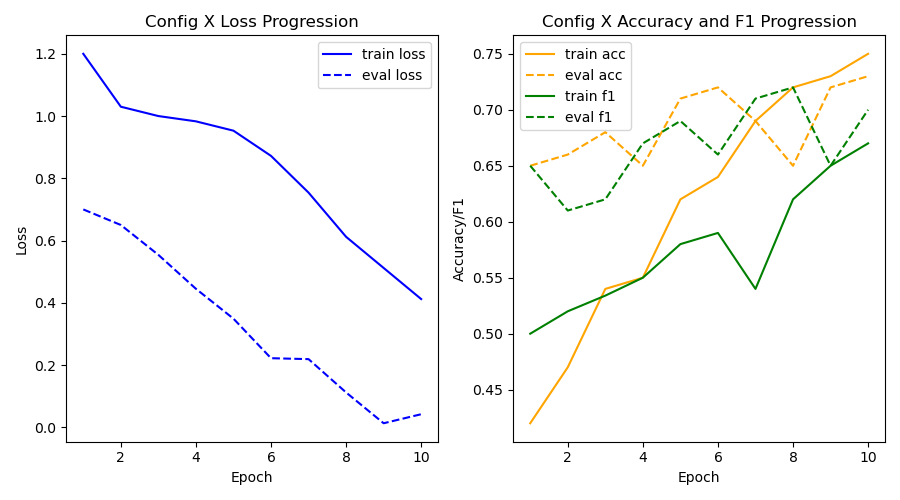


In [ ]:
df = pd.read_csv("results.csv")


Configuration 1 Analysis:
Trained for 4 epochs
Final training loss: 0.6908
Final validation loss: 0.7022
Best validation F1: 0.3058
Best validation accuracy: 0.4458

Observations:
- Early stopping triggered: model stopped improving
- Model converged: F1 score stabilized
- Poor performance: low F1 score suggests model struggled to learn
- Successful learning: loss decreased during training

Configuration 2 Analysis:
Trained for 11 epochs
Final training loss: 0.4548
Final validation loss: 0.5809
Best validation F1: 0.8028
Best validation accuracy: 0.7694

Observations:
- Strong performance: achieved high F1 score
- Successful learning: loss decreased during training

Configuration 3 Analysis:
Trained for 11 epochs
Final training loss: 0.2691
Final validation loss: 0.8380
Best validation F1: 0.8412
Best validation accuracy: 0.8112

Observations:
- Potential overfitting: large gap between training and validation loss
- Strong performance: achieved high F1 score
- Successful learning: loss

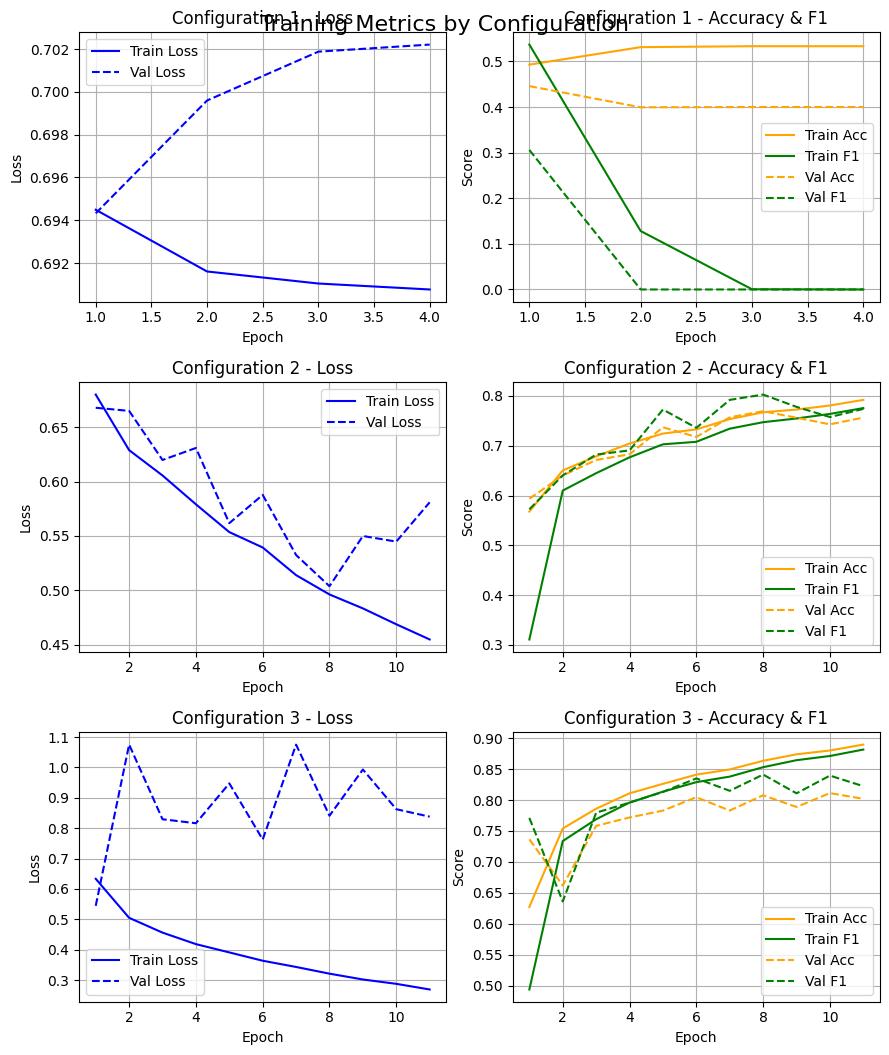

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(9, 11))

fig.suptitle('Training Metrics by Configuration', fontsize=16, y=0.95)

# Process each configuration
for config in range(1, 4):  # Configurations 1-3
    row = config - 1

    # Filter data for this configuration
    config_data = df[df['config'] == config]
    epochs = config_data['epoch']

    # Left plot: Losses
    # Training loss
    axes[row, 0].plot(epochs, config_data['train_loss'],
                      color='blue', label='Train Loss')
    # Validation loss
    axes[row, 0].plot(epochs, config_data['val_loss'],
                      color='blue', linestyle='--', label='Val Loss')

    axes[row, 0].set_title(f'Configuration {config} - Loss')
    axes[row, 0].set_xlabel('Epoch')
    axes[row, 0].set_ylabel('Loss')
    axes[row, 0].legend()
    axes[row, 0].grid(True)

    # Right plot: Accuracy and F1
    # Training metrics
    ln1 = axes[row, 1].plot(epochs, config_data['train_acc'],
                           color='orange', label='Train Acc')
    ln2 = axes[row, 1].plot(epochs, config_data['train_f1'],
                           color='green', label='Train F1')
    # Validation metrics
    ln3 = axes[row, 1].plot(epochs, config_data['val_acc'],
                           color='orange', linestyle='--', label='Val Acc')
    ln4 = axes[row, 1].plot(epochs, config_data['val_f1'],
                           color='green', linestyle='--', label='Val F1')

    axes[row, 1].set_title(f'Configuration {config} - Accuracy & F1')
    axes[row, 1].set_xlabel('Epoch')
    axes[row, 1].set_ylabel('Score')
    axes[row, 1].legend()
    axes[row, 1].grid(True)

plt.tight_layout()

# Analysis of each configuration
for config in range(1, 4):
    config_data = df[df['config'] == config]

    # Calculate key metrics
    final_train_loss = config_data['train_loss'].iloc[-1]
    final_val_loss = config_data['val_loss'].iloc[-1]
    best_val_f1 = config_data['val_f1'].max()
    best_val_acc = config_data['val_acc'].max()
    epochs_trained = len(config_data)

    print(f"\nConfiguration {config} Analysis:")
    print(f"Trained for {epochs_trained} epochs")
    print(f"Final training loss: {final_train_loss:.4f}")
    print(f"Final validation loss: {final_val_loss:.4f}")
    print(f"Best validation F1: {best_val_f1:.4f}")
    print(f"Best validation accuracy: {best_val_acc:.4f}")

    # Analyze problems and successes
    loss_gap = final_val_loss - final_train_loss
    early_stop = epochs_trained < max(df['epoch'])

    print("\nObservations:")
    if loss_gap > 0.5:  # High threshold for overfitting
        print("- Potential overfitting: large gap between training and validation loss")
    if early_stop:
        print("- Early stopping triggered: model stopped improving")
    if config_data['val_f1'].iloc[-3:].std() < 0.01:  # Check if F1 plateaued
        print("- Model converged: F1 score stabilized")
    if best_val_f1 > 0.8:
        print("- Strong performance: achieved high F1 score")
    elif best_val_f1 < 0.6:
        print("- Poor performance: low F1 score suggests model struggled to learn")

    # Check learning dynamics
    if config_data['train_loss'].iloc[0] > config_data['train_loss'].iloc[-1]:
        print("- Successful learning: loss decreased during training")
    else:
        print("- Learning issues: loss did not decrease significantly")

plt.show()


___

Student answer here:
___

* As the final step, instantiate a model with the config of the best run
* Load the `state_dict`
* Evaluate it on the test set
    * Don't forget to actviate evaluation mode and deactivate gradient calculation
* Comment on the performance
    * Did it generalize well? Why? Why not?
    * What could be done to improve the performance even further?
        * Consider also the hyperparameters from the third cell and discuss potential tradeoffs.

In [ ]:
# evaluate on test set
test_model = BiLSTM(vocab_size = VOCAB_SIZE,
        embedding_dim = 300,
        hidden_size = 256,
        rnn_size = 256,
        dropout = 0.5)

test_model.load_state_dict(best_model_params)
test_model.to(device)
test_loss, test_accuracy, test_f1 = process(test_model, test_loader, criterion)
print(f"Test Loss = {test_loss}, Test Accuracy = {test_accuracy}, Test F1 Score = {test_f1}")

Evaluating:   1%|          | 5/782 [00:00<00:17, 45.03batches/s]

<ipython-input-17-a242be9db2c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(padded_data), torch.tensor(labels),  batch_sequence_lengths)


Evaluating: 100%|██████████| 782/782 [00:11<00:00, 70.84batches/s]
Test Loss = 0.6527360952067375, Test Accuracy = 0.82996, Test F1 Score = 0.821108445903295


___

Student answer here: Test Loss = 0.6527360952067375, Test Accuracy = 0.82996, Test F1 Score = 0.821108445903295 \\
So it generalizes fairly well, with an F1 score similar to the one for the training data. The performance could be further improved by training the model for longer (more epochs), adding more parameters (more LSTM layers or larger embedding dimensions), because here the largest of our three possible hyperparameters performed best, so it could be a possibility that it might generalize even better with even more parameters. However, that would also be computationally more expensive and could maybe lead to overfitting and actually worse generalization than our current model.
___